#**Final Project**

In [2]:
import os
import cv2
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##3. Dataset

Load Source Dataset (done locally)

(367, 378)
(368, 378, 3)


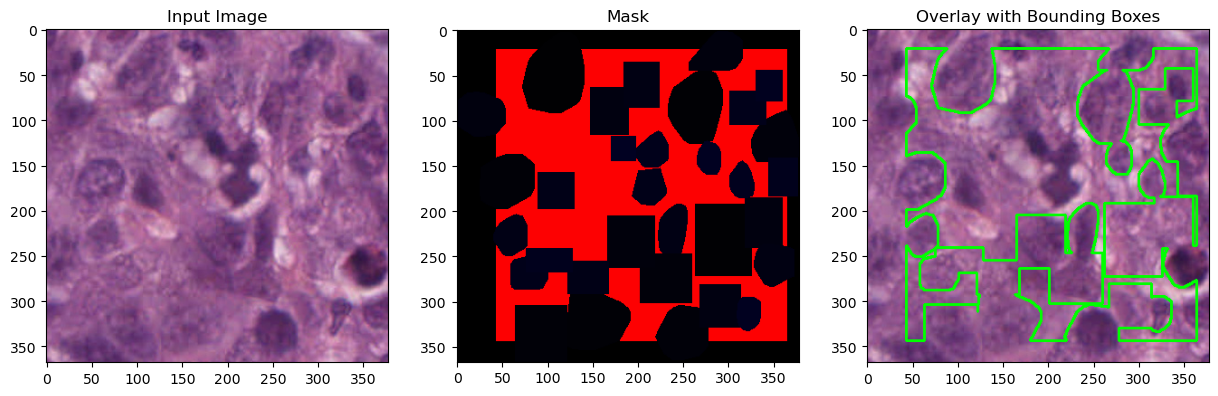

In [27]:
path ='/Users/angelawang/Downloads/QC'
rgb_dir = os.path.join(path, "rgb")
mask_dir = os.path.join(path, "mask")
csv_dir = os.path.join(path, "csv")
image_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)
csv_files = os.listdir(csv_dir)
image_files.sort()
mask_files.sort()
csv_files.sort()


def plot_sample_subject(image_path, mask_path):
    # Load the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask_gray.shape)
    print(image.shape)
    
    # Check shapes and resize mask if necessary
    if mask_gray.shape != image.shape[:2]:
        mask_gray = cv2.resize(mask_gray, (image.shape[1], image.shape[0]))
        

    # Threshold the mask to ensure binary regions
    _, binary_mask = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Find contours of the regions in the mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw on
    output_image = image.copy()         
    cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness 2
    


    # Plot the images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) )

    plt.subplot(1, 3, 3)
    plt.title("Overlay with Bounding Boxes")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    plt.show()

subject_id = "TCGA-A1-A0SP-DX1_id-5ea4095addda5f8398977ebc_left-11371_top-54469_bottom-54761_right-11671.png"

sample_image_path = os.path.join(rgb_dir, subject_id)
sample_mask_path = os.path.join(mask_dir, subject_id)

plot_sample_subject(sample_image_path,sample_mask_path )
